In [1]:
!pip install pymc3

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import os
import pandas as pd
from pandas_profiling import ProfileReport
import pymc3 as pm

# import data - データの読み込み

In [3]:
df_videos = pd.read_csv(os.path.join('..', 'data', 'AIcia_videos.csv'))
df_videos['公開日時'] = pd.to_datetime(df_videos['公開日時'])
df_videos['動画時間_s'] = pd.to_timedelta(df_videos['動画時間']).apply(lambda x: x.seconds)

df_videos = df_videos.drop(['動画時間'], axis=1)

df_videos.head()

動画タイトル       公開日時  経過日数  プレミア公開  \
0  【もう二度と迷わない】因子分析と主成分分析は何が違うの？【いろんな分析 vol. 3 】 #... 2020-04-30     4       1   
1  【深層学習】学習 - なぜ必要なのか？何をするのか？【ディープラーニングの世界 vol. 2... 2020-04-28     6       1   
2  【相関で情報を圧縮】主成分分析の気持ちを理解する【いろんな分析 vol. 2 】 #051 ... 2020-04-23    11       1   
3  【深層学習】ディープラーニングとは関数近似器である【ディープラーニングの世界 vol. 1 ... 2020-04-21    13       1   
4  【相関から構造を推定】因子分析の気持ちを理解する【いろんな分析 vol. 1 】#049 #... 2020-04-16    18       1   

   視聴回数  コメント  高評価件数  低評価件数   ln_経過日数   ln_視聴回数  ln_高評価件数  動画時間_s  
0   714    18     69      0  1.609438  6.572283  4.248495    1082  
1  1533    14     98      0  1.945910  7.335634  4.595120    1025  
2  1219    23    111      0  2.484907  7.106606  4.718499    1489  
3  2118    28    164      2  2.639057  7.658700  5.105945     530  
4  1462    18    112      1  2.944439  7.288244  4.727388    1283

In [10]:
profile = ProfileReport(df_videos, title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [11]:
profile

# Hierarchical Bayesian Modeling

In [4]:
n_videos = len(df_videos)

In [136]:
with pm.Model() as model:
    # prior to parameters
    alpha_plus = pm.Normal('alpha_plus', mu=-3, sd=2)
    beta_plus = pm.TruncatedNormal('beta_plus', mu=0, sd=1, lower=0)
    alpha_minus = pm.Normal('alpha_minus', mu=-3, sd=2)
    beta_minus = pm.TruncatedNormal('beta_minus', mu=0, sd=1, upper=0)
    
    # prior to fun
    fun = pm.Normal('fun', mu=0, sd=1, shape=n_videos)
    
    # play
    play = df_videos['視聴回数']
    
    # +1 and -1
    lambda_plus = pm.math.exp((alpha_plus + beta_plus * fun)) * play
    like = pm.Poisson('like', mu=lambda_plus, observed=df_videos['高評価件数'])
    
    lambda_minus = pm.math.exp((alpha_minus + beta_minus * fun)) * play
    dislike = pm.Poisson('dislike', mu=lambda_minus, observed=df_videos['低評価件数'])
    
    trace = pm.sample(1500, tune=1000, chains=5, random_seed=57)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [fun, beta_minus, alpha_minus, beta_plus, alpha_plus]


Sampling 5 chains for 1_000 tune and 1_500 draw iterations (5_000 + 7_500 draws total) took 11 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16bf15320>,
      dtype=object)

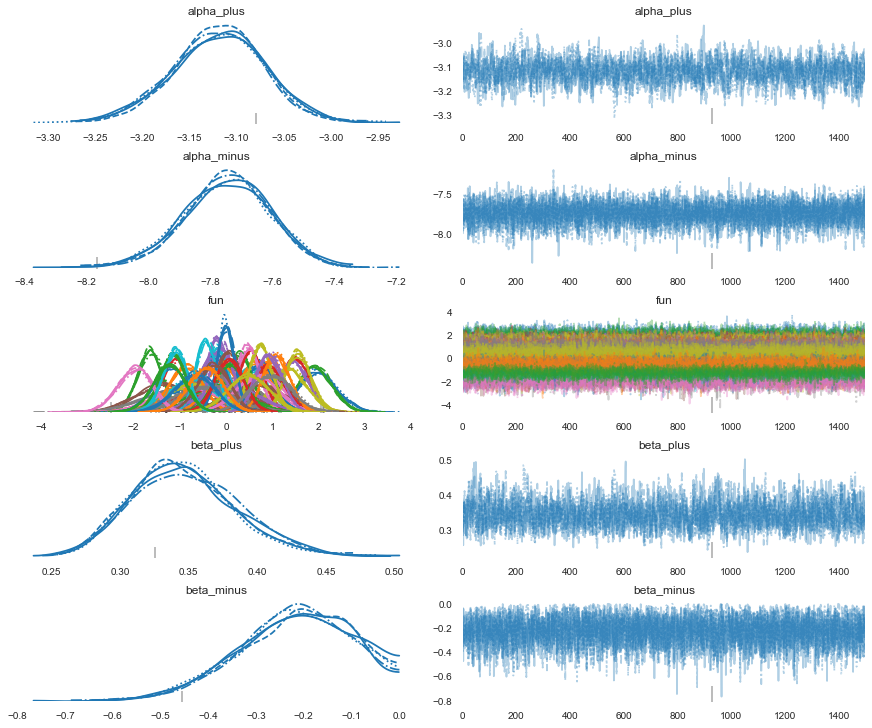

In [137]:
pm.traceplot(trace)

In [138]:
df_trace = pm.summary(trace)

df_trace

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
alpha_plus  -3.119  0.049  -3.213   -3.029      0.001    0.001    1302.0   
alpha_minus -7.745  0.136  -8.007   -7.493      0.002    0.001    5868.0   
fun[0]       1.999  0.399   1.285    2.782      0.006    0.005    3800.0   
fun[1]       0.976  0.327   0.395    1.620      0.005    0.004    4118.0   
fun[2]       1.942  0.348   1.323    2.618      0.006    0.005    2874.0   
...            ...    ...     ...      ...        ...      ...       ...   
fun[60]     -0.684  0.422  -1.488    0.104      0.006    0.004    5496.0   
fun[61]     -0.445  0.360  -1.123    0.220      0.005    0.004    5628.0   
fun[62]     -1.236  0.337  -1.881   -0.621      0.005    0.004    3808.0   
beta_plus    0.347  0.038   0.280    0.419      0.001    0.001    1566.0   
beta_minus  -0.219  0.118  -0.415   -0.000      0.002    0.001    4219.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
alpha_plus   1302.0    1305.0    1944.0    1.0  
alpha_minus  5834.0    5963.0    4169.0    1.0  
fun[0]       3800.0    3794.0    4454.0    1.0  
fun[1]       4110.0    4088.0    4505.0    1.0  
fun[2]       2874.0    2840.0    4213.0    1.0  
...             ...       ...       ...    ...  
fun[60]      4882.0    5501.0    4927.0    1.0  
fun[61]      5029.0    5631.0    4946.0    1.0  
fun[62]      3808.0    3775.0    4993.0    1.0  
beta_plus    1525.0    1628.0    2008.0    1.0  
beta_minus   4219.0    3651.0    2701.0    1.0  

[67 rows x 11 columns]

In [139]:
model_map = pm.find_MAP(model=model)
model_map

{'alpha_plus': array(-3.15332947),
 'beta_plus_lowerbound__': array(0.4709526),
 'alpha_minus': array(-7.69445275),
 'beta_minus_upperbound__': array(-0.28155996),
 'fun': array([ 0.50793035,  0.25254416,  0.47208644,  0.368334  ,  0.36224589,
         0.24989623,  0.2294624 ,  0.08905837,  0.35484492,  0.15577479,
         0.19469158,  0.1739435 ,  0.08712176,  0.14460789, -0.01983833,
         0.05349812,  0.13232059, -0.05668263,  0.37047359, -0.02415864,
        -0.03352525,  0.00237866, -0.33979158, -0.22875844, -0.04237382,
        -0.40697896, -0.0582794 , -0.38198621, -0.15314602, -0.07552654,
        -0.26891943, -0.2696795 , -0.04031662, -0.13060177,  0.05246522,
         0.23871718, -0.26580869, -0.07578466, -0.19148092, -0.18595123,
        -0.26645846, -0.18100373, -0.23841712,  0.24005426,  0.00264905,
         0.036626  ,  0.20832613, -0.15642418,  0.19194649, -0.07170835,
         0.02153512,  0.27289694,  0.04154113,  0.03938527,  0.2352092 ,
        -0.03964535, -0.43

In [140]:
model_map['fun']

array([ 0.50793035,  0.25254416,  0.47208644,  0.368334  ,  0.36224589,
        0.24989623,  0.2294624 ,  0.08905837,  0.35484492,  0.15577479,
        0.19469158,  0.1739435 ,  0.08712176,  0.14460789, -0.01983833,
        0.05349812,  0.13232059, -0.05668263,  0.37047359, -0.02415864,
       -0.03352525,  0.00237866, -0.33979158, -0.22875844, -0.04237382,
       -0.40697896, -0.0582794 , -0.38198621, -0.15314602, -0.07552654,
       -0.26891943, -0.2696795 , -0.04031662, -0.13060177,  0.05246522,
        0.23871718, -0.26580869, -0.07578466, -0.19148092, -0.18595123,
       -0.26645846, -0.18100373, -0.23841712,  0.24005426,  0.00264905,
        0.036626  ,  0.20832613, -0.15642418,  0.19194649, -0.07170835,
        0.02153512,  0.27289694,  0.04154113,  0.03938527,  0.2352092 ,
       -0.03964535, -0.43607771,  0.27812597,  0.15356516, -0.22335947,
       -0.1498943 , -0.0804228 , -0.26178462])

In [141]:
np.std(model_map['fun'])

0.2225540826654547

In [146]:
df_trace.loc['fun[0]':'beta_plus', ['mean']].sort_values('mean', ascending=False)

mean
fun[0]   1.999
fun[2]   1.942
fun[18]  1.570
fun[3]   1.531
fun[4]   1.466
...        ...
fun[40] -1.213
fun[62] -1.236
fun[25] -1.363
fun[22] -1.656
fun[56] -1.979

[64 rows x 1 columns]

In [147]:
df_videos.iloc[[0, 2, 18, 3, 4]]

動画タイトル       公開日時  経過日数  \
0   【もう二度と迷わない】因子分析と主成分分析は何が違うの？【いろんな分析 vol. 3 】 #... 2020-04-30     4   
2   【相関で情報を圧縮】主成分分析の気持ちを理解する【いろんな分析 vol. 2 】 #051 ... 2020-04-23    11   
18  【非 deep 最強機械学習】Gradient Boosted Trees の仕組み【勾配決... 2019-08-22   256   
3   【深層学習】ディープラーニングとは関数近似器である【ディープラーニングの世界 vol. 1 ... 2020-04-21    13   
4   【相関から構造を推定】因子分析の気持ちを理解する【いろんな分析 vol. 1 】#049 #... 2020-04-16    18   

    プレミア公開  視聴回数  コメント  高評価件数  低評価件数   ln_経過日数   ln_視聴回数  ln_高評価件数  動画時間_s  
0        1   714    18     69      0  1.609438  6.572283  4.248495    1082  
2        1  1219    23    111      0  2.484907  7.106606  4.718499    1489  
18       1  3102    15    240      1  5.549076  8.040125  5.484797     806  
3        1  2118    28    164      2  2.639057  7.658700  5.105945     530  
4        1  1462    18    112      1  2.944439  7.288244  4.727388    1283

In [148]:
df_videos.iloc[[40, 62, 25, 22, 56]]

動画タイトル       公開日時  経過日数  \
40  【東工大2019第1問】なんてきれいな不等式なんだ…！【Weitzenbockの不等式】 #... 2019-03-04   427   
62  【AI界で流行中！？】人間の皆さんに、GANごっこをお伝えします【暇を持て余したAIの遊び】... 2018-06-24   680   
25  【1分 Google Spreadsheet 解説 3-5 】INDEX + MATCH で... 2019-04-12   388   
22     【書評動画？】宇宙と数学と IUT 理論【めざせ ABC 予想】 #VRアカデミア #031 2019-06-09   330   
56   【微分幾何】多様体の内在的な定義【本編にドーナツは一切登場しません】 #VRアカデミア #008 2018-09-24   588   

    プレミア公開   視聴回数  コメント  高評価件数  低評価件数   ln_経過日数   ln_視聴回数  ln_高評価件数  動画時間_s  
40       1   2505    29     69      0  6.059123  7.826443  4.248495     850  
62       0   3192    11     91      5  6.523562  8.068716  4.521789     280  
25       0    649     2     14      0  5.963579  6.476972  2.708050     121  
22       1  18485    81    458     11  5.802118  9.824769  6.129050    1430  
56       0   4529     8     96      3  6.378426  8.418477  4.574711    1143

In [142]:
df_trace.loc['fun[0]':'beta_plus', 'mean'].describe()

count    64.000000
mean      0.008484
std       0.885584
min      -1.979000
25%      -0.558750
50%      -0.094500
75%       0.654250
max       1.999000
Name: mean, dtype: float64

In [ ]:
df_video

# fun vs comment

In [151]:
with pm.Model() as model_with_comment:
    # prior to parameters
    alpha_plus = pm.Normal('alpha_plus', mu=-3, sd=2)
    beta_plus = pm.TruncatedNormal('beta_plus', mu=0, sd=1, lower=0)
    alpha_minus = pm.Normal('alpha_minus', mu=-3, sd=2)
    beta_minus = pm.TruncatedNormal('beta_minus', mu=0, sd=1, upper=0)
    alpha_comment = pm.Normal('alpha_comment', mu=-3, sd=2)
    beta_comment = pm.TruncatedNormal('beta_comment', mu=0, sd=1, lower=0)
    
    # prior to fun
    fun = pm.Normal('fun', mu=0, sd=1, shape=n_videos)
    
    # prior to comment
    latent_comment = pm.Normal('latent_comment', mu=0, sd=1, shape=n_videos)
    
    # play
    play = df_videos['視聴回数']
    
    # +1, -1, comment
    lambda_plus = pm.math.exp((alpha_plus + beta_plus * fun)) * play
    like = pm.Poisson('like', mu=lambda_plus, observed=df_videos['高評価件数'])
    
    lambda_minus = pm.math.exp((alpha_minus + beta_minus * fun)) * play
    dislike = pm.Poisson('dislike', mu=lambda_minus, observed=df_videos['低評価件数'])
    
    lambda_comment = pm.math.exp((alpha_comment + beta_comment * latent_comment)) * play
    comment = pm.Poisson('comment', mu=lambda_comment, observed=df_videos['コメント'])
    
    trace = pm.sample(1500, tune=1000, chains=5, random_seed=57)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [latent_comment, fun, beta_comment, alpha_comment, beta_minus, alpha_minus, beta_plus, alpha_plus]


Sampling 5 chains for 1_000 tune and 1_500 draw iterations (5_000 + 7_500 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x168168588>,
      dtype=object)

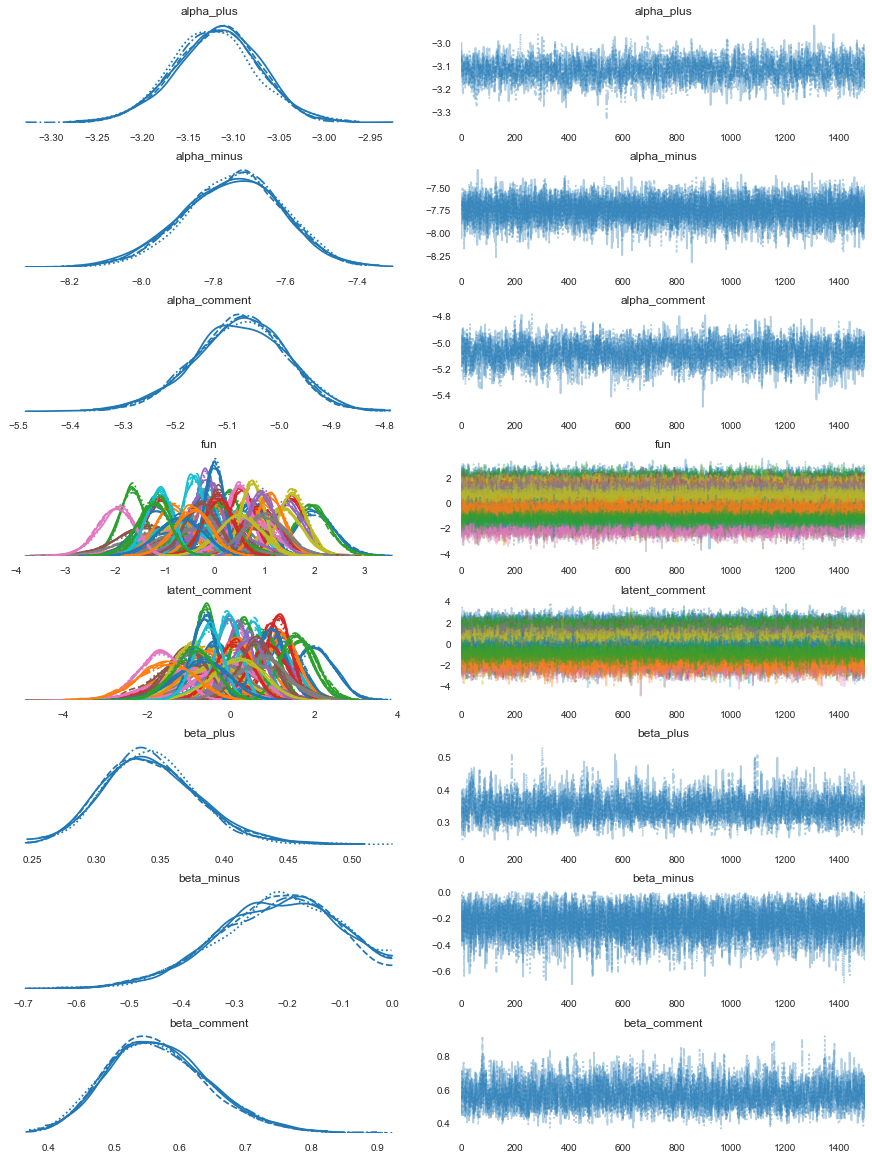

In [152]:
pm.traceplot(trace)

In [157]:
df_trace = pm.summary(trace)

df_trace

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_plus         -3.119  0.046  -3.205   -3.032      0.001    0.001   
alpha_minus        -7.746  0.134  -7.996   -7.496      0.001    0.001   
alpha_comment      -5.077  0.088  -5.253   -4.923      0.002    0.001   
fun[0]              2.016  0.393   1.226    2.711      0.005    0.004   
fun[1]              0.988  0.327   0.384    1.620      0.005    0.003   
...                   ...    ...     ...      ...        ...      ...   
latent_comment[61] -1.543  0.658  -2.790   -0.324      0.006    0.005   
latent_comment[62] -0.886  0.493  -1.850   -0.024      0.005    0.004   
beta_plus           0.344  0.037   0.273    0.411      0.001    0.001   
beta_minus         -0.219  0.114  -0.408   -0.002      0.002    0.001   
beta_comment        0.569  0.076   0.431    0.711      0.002    0.001   

                    ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
alpha_plus            1584.0  1582.0    1590.0    2861.0    1.0  
alpha_minus           8834.0  8755.0    9126.0    5324.0    1.0  
alpha_comment         2603.0  2599.0    2619.0    3146.0    1.0  
fun[0]                5536.0  5491.0    5550.0    5329.0    1.0  
fun[1]                5113.0  5113.0    5098.0    5062.0    1.0  
...                      ...     ...       ...       ...    ...  
latent_comment[61]   12740.0  8418.0   13199.0    5453.0    1.0  
latent_comment[62]    8710.0  6065.0    8989.0    5095.0    1.0  
beta_plus             2120.0  2107.0    2158.0    3136.0    1.0  
beta_minus            5691.0  5691.0    4946.0    3228.0    1.0  
beta_comment          2458.0  2446.0    2507.0    3829.0    1.0  

[132 rows x 11 columns]

In [166]:
df_latent = df_trace.loc['fun[0]':'latent_comment[62]', ['mean']].reset_index()
df_latent['variable'] = df_latent['index'].apply(lambda x: x.split('[')[0])
df_latent['index'] = df_latent['index'].apply(lambda x: x.split('[')[1].split(']')[0])
df_latent = df_latent.set_index(['index', 'variable']).unstack()

In [167]:
df_latent.describe()

mean               
variable        fun latent_comment
count     63.000000      63.000000
mean       0.004556      -0.003429
std        0.897287       0.825126
min       -1.992000      -1.722000
25%       -0.607000      -0.634000
50%       -0.100000      -0.040000
75%        0.671500       0.611000
max        2.016000       2.021000

In [168]:
df_latent.corr()

mean               
variable                  fun latent_comment
     variable                               
mean fun             1.000000       0.526433
     latent_comment  0.526433       1.000000